In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
X = np.load("MNIST-images.npy") / 255  # normalize the pixel values from [0,255] to [0,1]
y = np.load("MNIST-labels.npy")

# Dataset overview

First 25 samples and their predicted digit value in the title

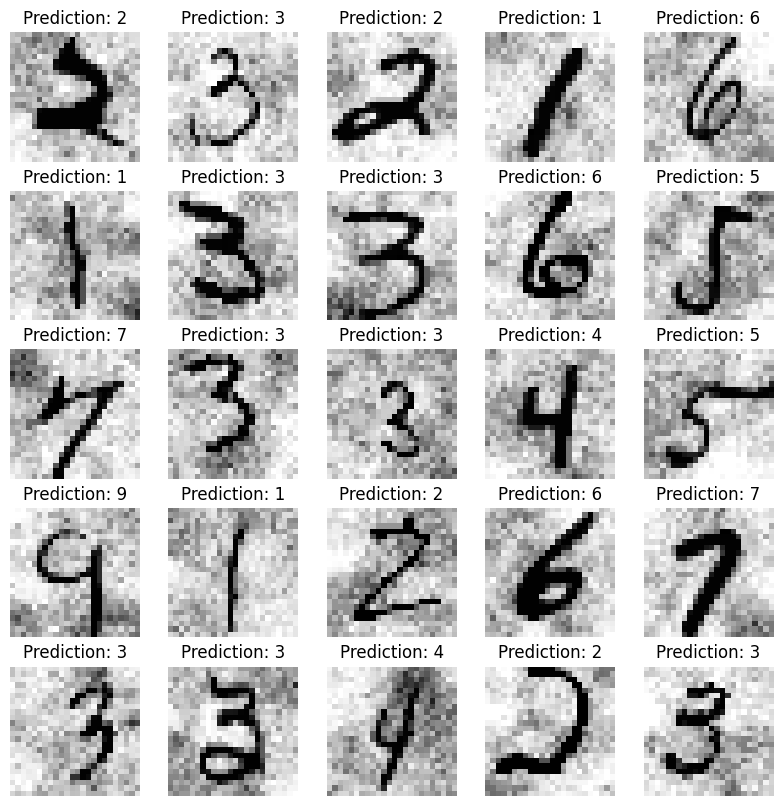

In [3]:
fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(X[i], cmap="Greys")
    ax.set_title(f"Prediction: {y[i]}")
    ax.axis("off")
fig.tight_layout(pad=0.5)
plt.show()

Digit distribution

3	35.95%
1	7.91%
7	7.35%
10	7.04%
2	6.99%
9	6.98%
0	6.95%
6	6.94%
4	6.85%
5	6.36%
8	0.7%


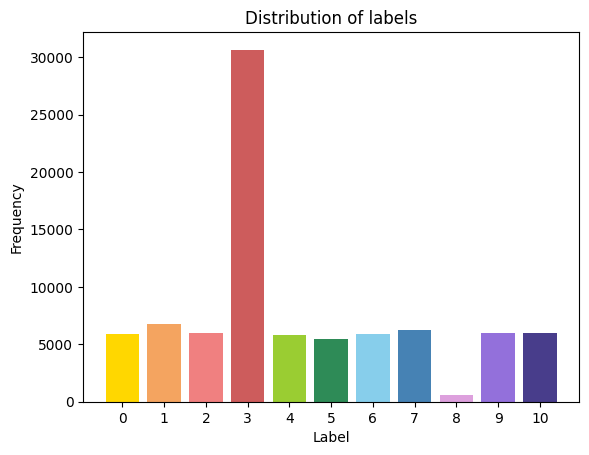

In [4]:
label, frequency = np.unique(y, return_counts=True)
digit_distribution = sorted(zip(label, frequency / sum(frequency) * 100), key=lambda x: x[1], reverse=True)
for t in digit_distribution:
    print(f"{t[0]}\t{round(t[1], 2)}%")

plt.bar(label, frequency, color=["gold", "sandybrown", "lightcoral", "indianred", "yellowgreen", "seagreen",
                                 "skyblue", "steelblue", "plum", "mediumpurple", "darkslateblue"])
plt.xticks(label)
plt.title("Distribution of labels")
plt.ylabel("Frequency")
plt.xlabel("Label")
plt.show()

# Data split

In [5]:
seed = 42
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, shuffle=True, random_state=seed)

skl_X_train = X_train.reshape(-1, 576)
skl_X_val = X_val.reshape(-1, 576)
skl_X_test = X_test.reshape(-1, 576)

tf_y_train = tf.keras.utils.to_categorical(y_train, 11)
tf_y_val = tf.keras.utils.to_categorical(y_val, 11)
tf_y_test = tf.keras.utils.to_categorical(y_test, 11)

val_acc = dict()  # dict with validation accuracy of each model

# Decision Tree

In [6]:
dt_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 4, 6, 8, 10],
    "max_features": [None, "sqrt", "log2"],
    "splitter": ["best", "random"]
}

dt_clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=dt_params, cv=5, n_jobs=5, verbose=3)
dt_clf.fit(skl_X_train, y_train)
dt_best_params = dt_clf.best_params_
print(dt_best_params)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'splitter': 'best'}


In [7]:
decision_tree = DecisionTreeClassifier(criterion=dt_best_params["criterion"],
                                       max_depth=dt_best_params["max_depth"],
                                       max_features=dt_best_params["max_features"],
                                       splitter=dt_best_params["splitter"],
                                       random_state=seed)
decision_tree.fit(skl_X_train, y_train)

y_pred = decision_tree.predict(skl_X_val)
m = tf.keras.metrics.Accuracy()
m.update_state(y_val, y_pred)

decision_tree_val_acc = m.result().numpy() * 100
val_acc["Decision tree"] = decision_tree_val_acc
print(f"Validation Accuracy: {round(decision_tree_val_acc, 3)}%")

Validation Accuracy: 77.289%


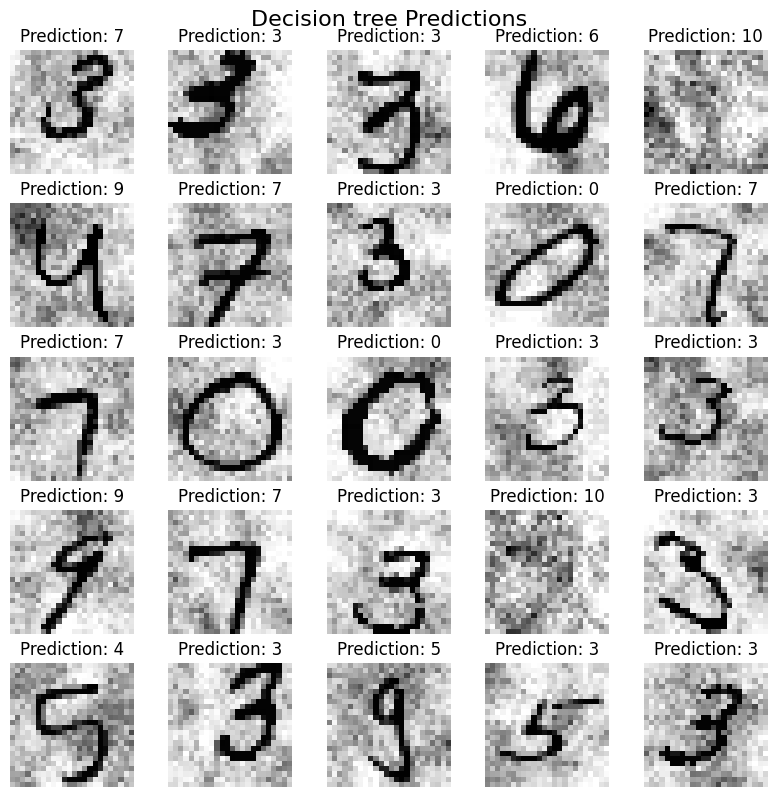

In [8]:
fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(X_val[i], cmap="Greys")
    ax.set_title(f"Prediction: {y_pred[i]}")
    ax.axis("off")
fig.suptitle("Decision tree Predictions", fontsize=16)
fig.tight_layout(pad=0.5)
plt.show()

Text(0.5, 0.98, 'Confusion Matrix for Decision tree')

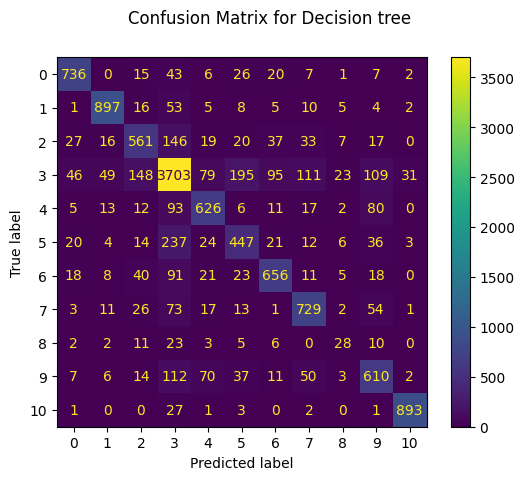

In [9]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
disp.figure_.suptitle("Confusion Matrix for Decision tree")

# KNN

In [10]:
knn_params = {"n_neighbors": list(range(1, 31))}
knn_clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, cv=5, n_jobs=5, verbose=3)
knn_clf.fit(skl_X_train, y_train)
knn_best_params = knn_clf.best_params_
print(knn_best_params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_neighbors': 2}


In [11]:
knn = KNeighborsClassifier(n_neighbors=knn_best_params["n_neighbors"])
knn.fit(skl_X_train, y_train)

y_pred = knn.predict(skl_X_val)
m = tf.keras.metrics.Accuracy()
m.update_state(y_val, y_pred)

knn_val_acc = m.result().numpy() * 100
val_acc["KNN"] = knn_val_acc
print(f"Validation Accuracy: {round(knn_val_acc, 3)}%")

Validation Accuracy: 82.738%


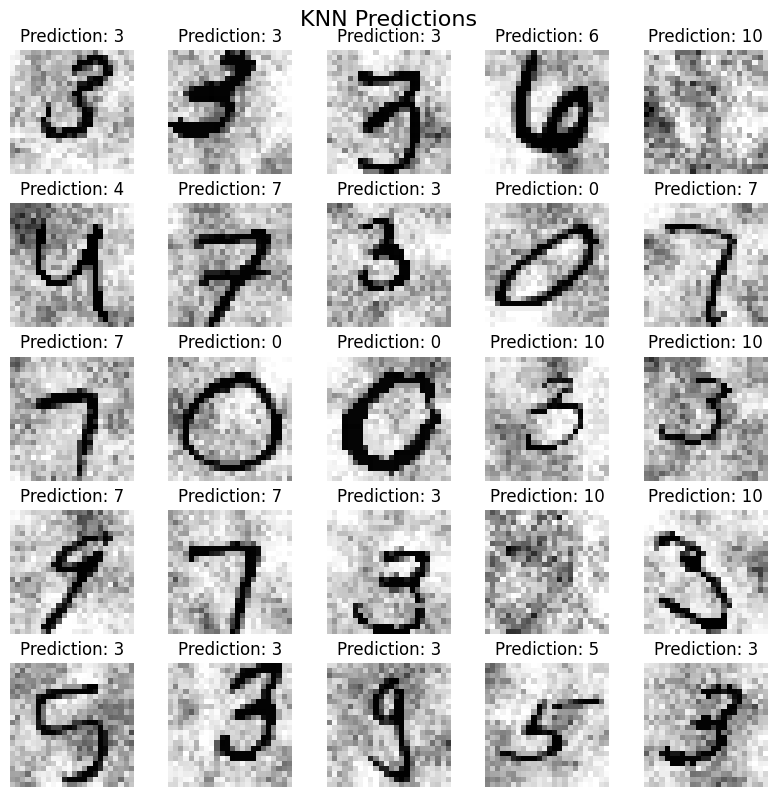

In [12]:
fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(X_val[i], cmap="Greys")
    ax.set_title(f"Prediction: {y_pred[i]}")
    ax.axis("off")
fig.suptitle("KNN Predictions", fontsize=16)
fig.tight_layout(pad=0.5)
plt.show()

Text(0.5, 0.98, 'Confusion Matrix for KNN')

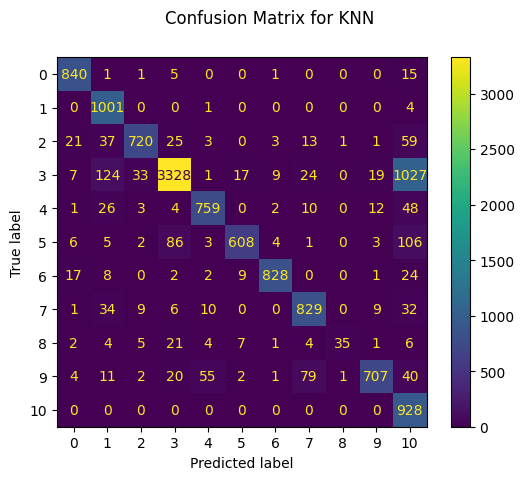

In [13]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
disp.figure_.suptitle("Confusion Matrix for KNN")

# CNN

In [46]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(24, 24, 1)))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(11, activation="softmax"))

model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=1e-4)

history = model.fit(X_train, tf_y_train, epochs=20, validation_data=(X_val, tf_y_val), callbacks=[early_stopping])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 22, 22, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 11, 11, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 4, 4, 64)         

In [47]:
cnn_val_acc = max(history.history['val_accuracy']) * 100
val_acc["CNN"] = cnn_val_acc
print(f"Validation Accuracy: {round(cnn_val_acc, 3)}%")
print(f"Training Accuracy: {round(max(history.history['accuracy']) * 100, 3)}%")

Validation Accuracy: 99.335%
Training Accuracy: 99.554%


400/400 [==============================] - 2s 4ms/step


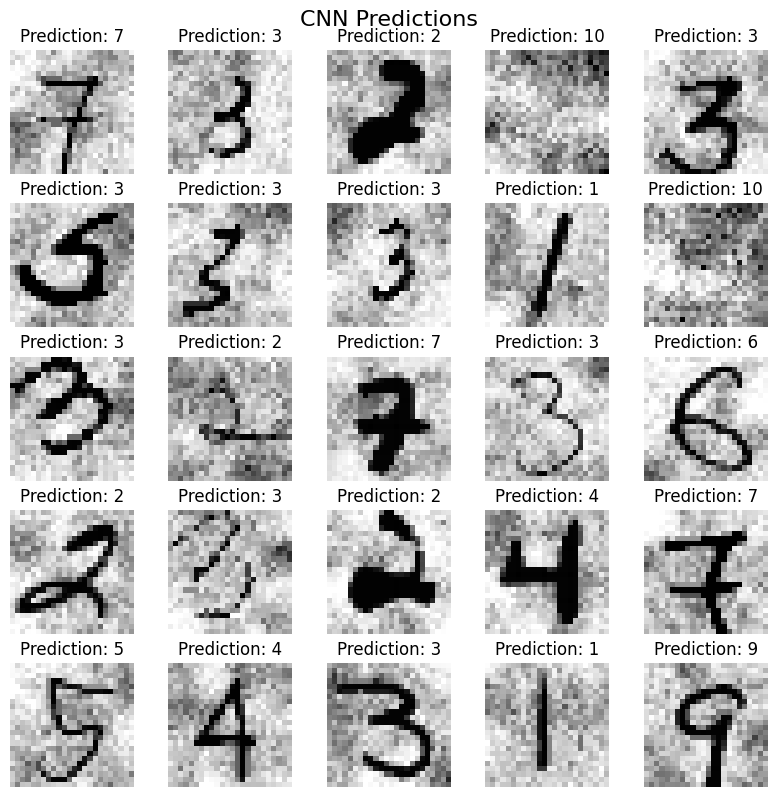

In [48]:
y_pred = model.predict(X_test).argmax(axis=1)
fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(X_test[i], cmap="Greys")
    ax.set_title(f"Prediction: {y_pred[i]}")
    ax.axis("off")
fig.suptitle("CNN Predictions", fontsize=16)
fig.tight_layout(pad=0.5)
plt.show()

Text(0.5, 0.98, 'Confusion Matrix for CNN')

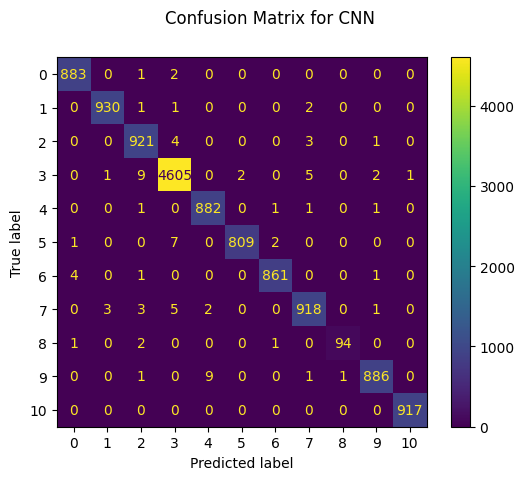

In [49]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix for CNN")

# Model Selection

In [54]:
for i, k in enumerate(sorted(val_acc, key=val_acc.get, reverse=True)):
    print(f"{i + 1}. {k}: {round(val_acc[k], 3)}%")

1. CNN: 99.335%
2. KNN: 82.738%
3. Decision tree: 77.289%


In [55]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, y_pred)  # (y_pred is model.predict(X_test).argmax(axis=1))
print(f"Test Accuracy: {round(m.result().numpy() * 100, 3)}%")

Test Accuracy: 99.335%


The best model in terms of accuracy is CNN

# CNN Model evaluation

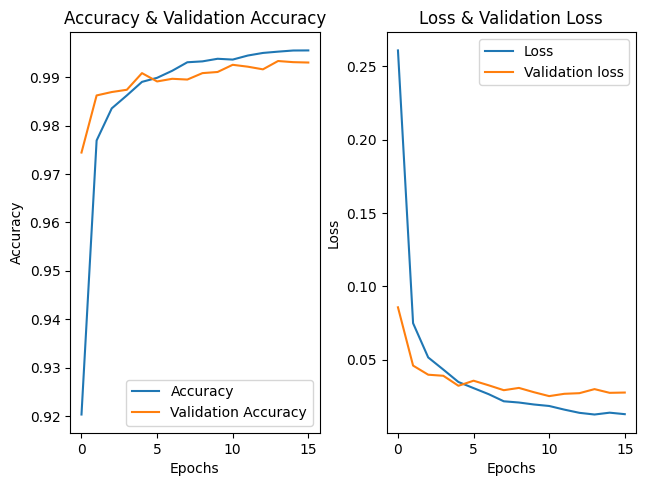

In [56]:
epoch = history.epoch

fig, ax = plt.subplots(1, 2)

ax[0].plot(epoch, history.history["accuracy"], label="Accuracy")
ax[0].plot(epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[0].set_title("Accuracy & Validation Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(epoch, history.history["loss"], label="Loss")
ax[1].plot(epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title("Loss & Validation Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

fig.tight_layout(pad=0.5)
plt.show()